<h3>实现神经网络实例</h3>

1. 准备数据

In [1]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#导入预处理模块
import torchvision.transforms as transforms
# 导入数据加载器
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

# 定义一些超参数
train_batch_size = 64       #训练集一批多少张图
test_batch_size = 128       #检验集一批多少张图
learning_rate = 0.01        #学习率
num_epoches = 3             #学习轮数

d:\anaconda\envs\DataAnalysisEnv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#定义预处理函数
#torchvision.transforms是pytorch中的图像预处理包
#transforms.Compose：整合多个步骤
#transforms.ToTensor()：把灰度范围从0-255变换到0-1之间
#transforms.Normalize：用均值和标准差归一化张量图像。对每个通道而言，Normalize执行以下操作：image=(image-mean)/std
#(RGB)mean和std分别通过(0.5,0.5,0.5)和(0.5,0.5,0.5)进行指定。原来的0-1最小值0则变成(0-0.5)/0.5=-1，而最大值1则变成(1-0.5)/0.5=1.
#灰度图则是(0.5),(0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
#下载数据，并对数据进行预处理，得到dataset
#直接将data文件夹放好，免除下载麻烦：https://cloud.tsinghua.edu.cn/d/e059fcdaa9714454bfc3/
train_dataset = mnist.MNIST(
    root='./data', 
    train=True, 
    transform=transform
    #, download=True
)
test_dataset = mnist.MNIST(
    root='./data', 
    train=False, 
    transform=transform
)
#得到一个生成器（dataloader）
#torch.utils.data.DataLoader
#输入：dataset（数据集，一种特定类型）、batch_size（每批样本量）、shuffle（是否打乱）等
#构建Dataloader对象
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=train_batch_size, 
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=test_batch_size,
    shuffle=False
)

2. 可视化源数据

2
torch.Size([128, 1, 28, 28])
128 tensor([2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1,
        2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2,
        4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0,
        7, 1, 1, 2, 1, 5, 3, 3, 9, 7, 8, 6, 5, 6, 1, 3, 8, 1, 0, 5, 1, 3, 1, 5,
        5, 6, 1, 8, 5, 1, 7, 9, 4, 6, 2, 2, 5, 0, 6, 5, 6, 3, 7, 2, 0, 8, 8, 5,
        4, 1, 1, 4, 0, 3, 3, 7])


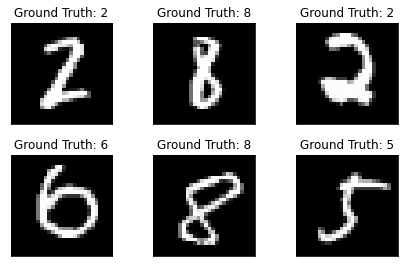

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
next(examples)
next(examples)
batch_idx, (example_data, example_targets) = next(examples)   #随机找一批图
print(batch_idx)          #2（第几批（每批128个图））
print(example_data.shape) #torch.Size([128, 1, 28, 28])，example_data：dim0为图号，dim1为灰度，后两维为尺寸
print(len(example_targets),example_targets) #128  example_targets为这128张图里每个图所属label（0~9）

fig = plt.figure()
for i in range(6):        #显示前六张
  plt.subplot(2,3,i+1)
  plt.tight_layout()      #自动调整子图参数，使之填满整个图像区域
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])          #去除坐标轴
  plt.yticks([])


3. 构建模型

In [6]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    '''
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):    # 28*28, 300, 100, 10
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x
    '''    

        # 除通过 Sequential 建立网络，还可以采用如下两种方法:

        # 1) Specify how data will pass through your model

        # self.fc1 = nn.Linear(in_dim, n_hidden_1)
        # self.BatchNorm1 = nn.BatchNorm1d(n_hidden_1)
        # self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        # self.BatchNorm2 = nn.BatchNorm1d(n_hidden_2)
        # self.fc3 = nn.Linear(n_hidden_2, out_dim)
        # 并在 forward() 中顺次连接

        #   def forward(self, x):
            #   x = self.fc1(x)
            #   x = self.BatchNorm1(x)
            #   x = F.relu(x)
            #   x = fc2(x)
            #   x = self.BatchNorm2(x)
            #   x = F.relu(x)
            #   x = fc3(x)
            #   return x


        # 2) building weights and biases by nn.Parameter()
        
    def __init__(self,in_dim,n_hidden1,n_hidden2,out_dim):
        super(Net, self).__init__()
        # layer1
        self.W1 = nn.Parameter(torch.randn(n_hidden1,in_dim),requires_grad=True)
        self.b1 = nn.Parameter(torch.zeros(n_hidden1), requires_grad=True)
        self.BatchNorm1 = nn.BatchNorm1d(n_hidden1)

        # layer2
        self.W2 = nn.Parameter(torch.randn(n_hidden2,n_hidden1),requires_grad=True)
        self.b2 = nn.Parameter(torch.zeros(n_hidden2), requires_grad=True)
        self.BatchNorm2 = nn.BatchNorm1d(n_hidden2)
        
        # layer3
        self.W3 = nn.Parameter(torch.randn(out_dim,n_hidden2),requires_grad=True)
        self.b3 = nn.Parameter(torch.zeros(out_dim), requires_grad=True)
        

    def forward(self, x):

        x = torch.matmul(x, self.W1.T) + self.b1.view(1, -1)        #数据向量都是行向量
        x = self.BatchNorm1(x)
        x = F.relu(x)

        x = torch.matmul(x, self.W2.T) + self.b2.view(1, -1)
        x = self.BatchNorm2(x)
        x = F.relu(x)

        x = torch.matmul(x, self.W3.T) + self.b3.view(1, -1)
        return x 
    
            

In [7]:
lr = 0.01
momentum = 0.9  #https://blog.csdn.net/gaoxueyi551/article/details/105238182

In [8]:
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
#    print("Let's use", torch.cuda.device_count(), "GPUs")
#    # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
#    model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

4. 训练模型

In [9]:
# 开始训练
losses = []             # 每轮训练得到的训练集loss均值（以轮为单位，共有epoch个元素，用于最后画图）
acces = []              # 每轮训练得到的训练集准确率均值（以轮为单位，共有epoch个元素，用于最后画图）
eval_losses = []        # 测试集...
eval_acces = []


for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()                           #将model设成训练模式（nn.module自带的）
    
    # 以批为单位遍历训练集
    for img, label in train_loader:         # img：64/128*1*28*28，是批处理产生的矩阵，这里详见前文Dataloader的构造
        img=img.to(device)
        label = label.to(device)            # 将img和label加载到gpu上
        img = img.view(img.size(0), -1)     # img.size(0)是每批图片数，相当于把每张图片都作为输入矩阵的一行

        # 前向计算，得到预测输出out
        out = model(img)                    # 将该批图片传入model，得到神经网络最后一层的输出（原始分布，还没经过Softmax和CrossEntropyLoss）
        print(out.dtype,'******',label.dtype)
        loss = criterion(out, label)        # 计算损失函数，out为神经网络最后一层的输出结果（每个行向量为一个样本属于各label的概率），label为该批样本真实结果向量

        # 反向传播，优化模型参数
        optimizer.zero_grad()               # 清除上一轮的梯度
        loss.backward()                     # 对损失函数loss进行一次反向传播
        optimizer.step()                    # 进行一次参数优化（也即依据反向传播计算出的梯度等更新w、b）

        # 记录误差（最终也即训练集所有样本交叉熵的均值）
        train_loss += loss.item()           # 将该批样本的交叉熵均值加入train_loss中（后边输出时会再取平均）
                                            # tensor.item()是以更高精度取出一个单元素tensor的数值，常用于求误差、准确率等
        
        # 计算分类的准确率
        _, pred = out.max(1)                # pred是每一行最大值的索引，实际上也就是预测得到的label（"_"一般表示一个不关心的变量）
        num_correct = (pred == label).sum().item()      # 该批样本中，模型预测结果正确的样本数
        acc = num_correct / img.shape[0]                # img.shape[0]即一批中的样本总数，此处即64。acc即为该批样本预测准确率
        train_acc += acc                                # 将该批样本的预测准确率加入train_acc中（后边输出时会再取平均）
        
    losses.append(train_loss / len(train_loader))       # 每批样本交叉熵均值的均值，也即本轮训练得到的训练集所有样本的交叉熵的均值
    acces.append(train_acc / len(train_loader))         # 本轮训练得到的训练集所有样本的预测准确率均值

########################################################
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    
    model.eval()                    # 将模型改为预测（验证）模式

    # 以批为单位遍历测试集
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)

        # 前向计算，得到预测输出out
        out = model(img)
        loss = criterion(out, label)
        # 在预测模式，不再有反向传播优化模型步骤


        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))


torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.float32 ****** torch.int64
torch.floa

KeyboardInterrupt: 

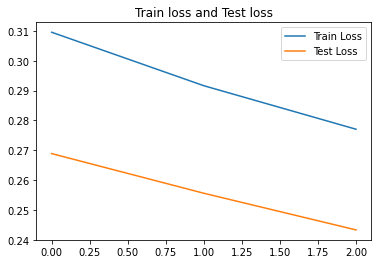

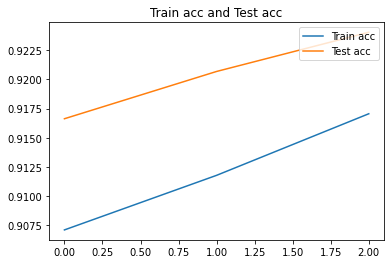

In [22]:
# 画出损失函数变化情况
plt.figure()
plt.title('Train loss and Test loss')
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')

# 画出预测准确率变化情况
plt.figure()
plt.title('Train acc and Test acc')
plt.plot(np.arange(len(acces)), acces)
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.legend(['Train acc', 'Test acc'], loc='upper right')
